# Imports

In [ ]:
! pip install torchaudio wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 6.9MB/s 
     |████████████████████████████████| 112kB 16.4MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 163kB 15.6MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=7ac1bcaeb17c1b4af780356a1b5fa91fcc20378b0375846218f32923e48c4038
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=31f3854d40ad97538150bb2aff52846f24929f15ee3422fe942aab95f8a318ab
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=bf5e

In [ ]:
import copy
import pickle
import os
import io
import glob
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict

import shutil
from zipfile import ZipFile

from sklearn.metrics import mean_absolute_error

import torch
from torchvision import datasets, models, transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch import optim

import librosa
from librosa.display import specshow
import torchaudio

import wandb 
project_dir = 'drive/My Drive/projects/engage_ai_recruiter/'
models_dir = 'drive/My Drive/projects/engage_ai_recruiter/models/audio/'
data_dir = 'drive/My Drive/projects/engage_ai_recruiter/data/'

In [ ]:
! wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: c20b76df6485e21219129accd98674118158da7b
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [ ]:
! cp drive/My\ Drive/projects/engage_ai_recruiter/data/all_wav.zip all_wav.zip

In [ ]:
shutil.unpack_archive('all_wav.zip', '', 'zip')

In [ ]:
all_wav = os.listdir('all_wav')
len(all_wav)

8000

# Data Preprocessing

## Dataset Creation - WAV & Annotation

In [ ]:
pwd = b'zeAzLQN7DnSIexQukc9W'
with ZipFile(data_dir + 'Chalearn Data/val-annotation-e.zip') as zf:
    zf.extractall(pwd=pwd)

with ZipFile(data_dir + 'Chalearn Data/train-annotation.zip') as zf:
    zf.extractall()

In [ ]:
with open('annotation_training.pkl', 'rb') as p:
    annotation_training = pickle.load(p, encoding='latin1')

with open('annotation_validation.pkl', 'rb') as p:
    annotation_validation = pickle.load(p, encoding='latin1')

In [ ]:
annotations = annotation_training.copy()

for trait in annotation_validation.keys():
    for item in annotation_validation[trait]:
        annotations[trait][item] = annotation_validation[trait][item]

# example length
len(annotations['conscientiousness'])

8000

In [ ]:
# creating Specgram_InterviewScore.csv
wav_ids = []
o_score = []
c_score = []
e_score = []
a_score = []
n_score = []
i_score = []
for vid_file in annotations['openness']:
    wav = vid_file.replace('mp4', 'wav')
    if wav in all_wav:
        wav_ids.append(wav)
        o_score.append(annotations['openness'][vid_file])
        c_score.append(annotations['conscientiousness'][vid_file])
        e_score.append(annotations['extraversion'][vid_file])
        a_score.append(annotations['agreeableness'][vid_file])
        n_score.append(annotations['neuroticism'][vid_file])
        i_score.append(annotations['interview'][vid_file])

df = pd.DataFrame()
df['wav_id'] = wav_ids
df['openness'] = o_score
df['conscientiousness'] = c_score
df['extraversion'] = e_score
df['agreeableness'] = a_score
df['neuroticism'] = n_score
df['interview'] = i_score

print(len(df))
df.head()

8000


,wav_id,openness,conscientiousness,extraversion,agreeableness,neuroticism,interview
0,J4GQm9j0JZ0.003.wav,0.488889,0.601942,0.523364,0.626374,0.552083,0.504673
1,zEyRyTnIw5I.005.wav,0.366667,0.582524,0.345794,0.472527,0.375000,0.457944
2,nskJh7v6v1U.004.wav,0.511111,0.485437,0.252336,0.406593,0.291667,0.373832
3,6wHQsN5g2RM.000.wav,0.377778,0.398058,0.457944,0.505495,0.489583,0.457944
4,dQOeQYWIgm8.000.wav,0.622222,0.621359,0.607477,0.406593,0.489583,0.570093


In [ ]:
df.to_csv(data_dir + 'WAV_OCEANI.csv', index=False)

## DALI (NVIDIA Data Loading Library)

In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
! pip3 install --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali-cuda100

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 264.6MB 29kB/s 


In [ ]:
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

In [ ]:
# example function
# def get_melspecgram(y):
#     mel_specgram = torchaudio.transforms.MelSpectrogram(n_fft=1024,
#                                                         hop_length=256,
#                                                         n_mels=40,
#                                                         sample_rate=16000)(y_mono)
#     mel_specgram = librosa.power_to_db(mel_specgram, ref=np.max)    

#     specshow(mel_specgram, fmax=8000)
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png', bbox_inches='tight')
#     buf.seek(0)
#     return buf

In [ ]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, csv_file, root_dir, indices):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.wav_df = pd.read_csv(csv_file)
        self.wav_df = self.wav_df.iloc[indices, :]

    def __iter__(self):
        self.i = 0
        self.n = len(self.wav_df)
        return self

    def __next__(self):
        b_wavs = []
        b_labels = []
        for _ in range(self.batch_size):
            wav = os.path.join(self.root_dir, self.wav_df.iloc[self.i, 0])
            y, sr = torchaudio.load(wav)
            y = y.squeeze(0).numpy()
            y = y[:(16000 * 15)]
            b_wavs.append(y)

            labels = self.wav_df.iloc[self.i, 1:].values.astype(np.float32)
            b_labels.append(labels)

            self.i = (self.i + 1) % self.n
        return (b_wavs, b_labels)

    @property
    def size(self,):
        return len(self.wav_df)

    next = __next__

In [ ]:
class MelSpectrogramPipeline(Pipeline):
    def __init__(self, 
                 external_data,
                 device, 
                 batch_size, 
                 specgram_dict, 
                 num_threads=1, 
                 device_id=0):
        super(MelSpectrogramPipeline, self).__init__(batch_size, num_threads, device_id)

        self.device = device
        self.data_iterator = iter(external_data)
        self.specgram_dict = specgram_dict
        
        # input
        self.input_wav = ops.ExternalSource()
        self.input_label = ops.ExternalSource()

        # audio
        self.spectrogram = ops.Spectrogram(device=self.device,
                                           nfft=self.specgram_dict['n_fft'],
                                           window_length=self.specgram_dict['n_fft'],
                                           window_step=self.specgram_dict['hop_length'])
        self.mel_fbank = ops.MelFilterBank(device=self.device,
                                           sample_rate=self.specgram_dict['sr'],
                                           nfilter = self.specgram_dict['n_mels'],
                                           freq_high = self.specgram_dict['f_max'])
        self.dB = ops.ToDecibels(device=self.device,
                                 multiplier = 10.0,
                                 cutoff_db = -80)
        
        # image
        self.decode = ops.ImageDecoder(device=self.device)
        self.res = ops.Resize(device=self.device, resize_x=224, resize_y=224)
        self.norm = ops.CropMirrorNormalize(device = self.device,
                                            mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])
        
    def define_graph(self):
        # audio transforms
        self.y = self.input_wav()
        self.labels = self.input_label()
        self.y = self.y.gpu() if self.device == 'gpu' else self.y
        specgram = self.spectrogram(self.y)
        mel_specgram = self.mel_fbank(specgram)
        mel_specgram_db = self.dB(mel_specgram)
        return (mel_specgram_db, self.labels)

    def iter_setup(self):
        y, labels = self.data_iterator.next()
        self.feed_input(self.y, y)
        self.feed_input(self.labels, labels)

In [ ]:
# Creating data indices for training and validation splits:
wav_df = pd.read_csv(data_dir + 'WAV_OCEANI.csv')

validation_split = 0.2
shuffle_dataset = True
random_seed = 42

dataset_size = len(wav_df)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# sampling indices
train_indices, val_indices = indices[split:], indices[:split]

# get iterator lengths
len_train_iterator = len(train_indices) // 32 
len_val_iterator = len(val_indices) // 32 

len_train_iterator, len_val_iterator

(198, 49)

In [ ]:
train_eii = ExternalInputIterator(batch_size=32, 
                            csv_file=data_dir + 'WAV_OCEANI.csv', 
                            root_dir='all_wav',
                            indices=train_indices)

val_eii = ExternalInputIterator(batch_size=32, 
                            csv_file=data_dir + 'WAV_OCEANI.csv', 
                            root_dir='all_wav',
                            indices=val_indices)

In [ ]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

def build_dali_pipeline(device):
    specgram_dict = {'n_fft': 1024,
                    'hop_length': 256,
                    'n_mels': 64,
                    'sr': 16000,
                    'f_max': 8000,
                    'duration': 15}

    train_pipe = MelSpectrogramPipeline(external_data=train_eii, 
                                        device=device,
                                        specgram_dict=specgram_dict,
                                        batch_size=32,
                                        device_id=0)
    train_pipe.build()

    val_pipe = MelSpectrogramPipeline(external_data=train_eii,
                                    device=device,
                                    specgram_dict=specgram_dict, 
                                    batch_size=32, 
                                    device_id=0)
    val_pipe.build()

    train_iterator = DALIGenericIterator(train_pipe, 
                                        ['mel_specgram_db', 'labels'], 
                                        size=train_eii.size)
    val_iterator = DALIGenericIterator(val_pipe, 
                                    ['mel_specgram_db', 'labels'], 
                                    size=val_eii.size)
    return train_iterator, val_iterator, len_train_iterator, len_val_iterator

## PyTorch Dataloader

In [ ]:
# load data
specgram_df = pd.read_csv(data_dir + 'Specgram_OCEANI.csv')
# with open(data_dir + 'mfcc_7934n_13200d.pkl', 'rb') as p:
#     mfcc = pickle.load(p)
print(len(specgram_df))

7934


In [ ]:
class SpecgramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.specgram_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # self.mfcc = mfcc

    def __len__(self):
        return len(self.specgram_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.specgram_df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.specgram_df.iloc[idx, 1:].values.astype(np.float32)
        # for key, value in labels.items():
        #     labels[key] = torch.Tensor([value])
        labels = torch.from_numpy(labels)
        # mfcc_vec = torch.Tensor(self.mfcc[self.specgram_df.iloc[idx, 0].replace('png', 'mp4')])

        if self.transform:
            image = self.transform(image)

        return (image, labels)

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [ ]:
# Creating data indices for training and validation splits:
validation_split = 0.2
shuffle_dataset = True
random_seed = 42

dataset_size = len(specgram_df)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
specgram_data = SpecgramDataset(csv_file=os.path.join(data_dir, 'Specgram_OCEANI.csv'),
                                # mfcc=mfcc,
                                root_dir='specgrams1',
                                transform=transform)

train_dataloader = DataLoader(specgram_data, 
                              sampler=train_sampler, 
                              batch_size=8, 
                              num_workers=2,
                              pin_memory=True)

val_dataloader = DataLoader(specgram_data, 
                            sampler=val_sampler, 
                            batch_size=8, 
                            num_workers=2,
                            pin_memory=True)

In [ ]:
len(train_dataloader), len(val_dataloader)

(794, 199)

In [ ]:
def display_image(image):
    fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    return ax.imshow(image)

In [ ]:
b_images, b_labels = next(iter(train_dataloader))
print(b_images.shape)
# print(b_labels.shape)
print(b_labels)

# display_image(b_images[0])

torch.Size([8, 3, 224, 224])
tensor([[0.6111, 0.8932, 0.6636, 0.6374, 0.6875, 0.7196],
        [0.9000, 0.7087, 0.7757, 0.6813, 0.8333, 0.6916],
        [0.7556, 0.7282, 0.7009, 0.7802, 0.6771, 0.6822],
        [0.6667, 0.4951, 0.5327, 0.5714, 0.6354, 0.5327],
        [0.6556, 0.5340, 0.5888, 0.5165, 0.6875, 0.6355],
        [0.4333, 0.8252, 0.1776, 0.6154, 0.6667, 0.5888],
        [0.7111, 0.6602, 0.5514, 0.6593, 0.6354, 0.5234],
        [0.3111, 0.2621, 0.2617, 0.2637, 0.2708, 0.2617]])


In [ ]:
b_images, b_labels = next(iter(val_dataloader))
print(b_images.shape)
# print(b_labels.shape)
print(b_labels)

torch.Size([8, 3, 224, 224])
tensor([[0.6667, 0.5728, 0.5421, 0.6703, 0.6354, 0.5047],
        [0.6778, 0.7961, 0.4953, 0.5934, 0.6562, 0.6262],
        [0.5778, 0.5340, 0.4673, 0.4396, 0.4271, 0.5327],
        [0.4778, 0.2233, 0.2710, 0.3846, 0.3333, 0.2243],
        [0.3222, 0.1845, 0.3551, 0.4835, 0.3854, 0.3084],
        [0.6667, 0.6019, 0.5047, 0.6484, 0.6771, 0.5514],
        [0.6111, 0.3981, 0.4766, 0.5495, 0.4375, 0.4486],
        [0.3111, 0.6602, 0.4579, 0.4945, 0.4688, 0.5047]])


# Pretrained Resnet101 + MFCCs - Late Fusion Model

In [ ]:
device = torch.device('cuda')

In [ ]:
resnet = models.resnext101_32x8d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
resnet;

In [ ]:
# trainable parameters
sum(p.numel() for p in resnet.parameters() if p.requires_grad)

88791336

In [ ]:
class ResnetOut(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [ ]:
# Freeze parameters so we don't backprop through them
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = ResnetOut()

In [ ]:
resnet;

In [ ]:
# define our own regressor
regressor = nn.Sequential(nn.Linear(15248, 2048),
                          nn.ReLU(),
                          nn.Dropout(p=0.25),
                          nn.Linear(2048, 512),
                          nn.ReLU(),
                          nn.Dropout(p=0.25),
                          nn.Linear(512, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.25),
                          nn.Linear(128, 1))

In [ ]:
# concatenates resnet output & mfccs 
class Ensemble(nn.Module):
    def __init__(self, resnet, regressor):
        super(Ensemble, self).__init__()

        self.resnet = resnet
        self.regressor = regressor

    def forward(self, x1, mfcc_vec):
        x1 = self.resnet(x1)

        # concatenate resnet output & mfcc vector (2048 + 13200)
        x = torch.cat((x1, mfcc_vec), dim=1)

        x = self.regressor(x)

        return x


In [ ]:
model = Ensemble(resnet, regressor)
model.to(device);

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.regressor.parameters(), lr=0.001)
epochs = 30
save_best_only = True
early_stopping_limit = 4
model_name = 'resnet-dnn_specgram-mfcc_ensemble_6000data'

In [ ]:
training_losses, val_losses = [], []
prev_val_loss, min_val_loss = 0, 9999
early_stopping_cnt = 0

for epoch in range(epochs):
    # Training
    train_loss, train_steps = 0, 0
    model.train()

    for batch in tqdm(train_dataloader, desc='Epoch ' + str(epoch)):
        b_images, b_mfccs, b_labels = batch
        b_images, b_mfccs, b_labels = b_images.to(device), b_mfccs.to(device), b_labels.to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        logits = model.forward(b_images, b_mfccs)

        # calc loss
        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        train_steps += 1
    
    training_losses.append(train_loss/len(train_dataloader))
    print('Train MSE loss:', train_loss/len(train_dataloader))

    # Validation
    val_loss, val_steps = 0, 0
    pred, true = [], []

    model.eval()
    for batch in val_dataloader:
        b_images, b_mfccs, b_labels = batch
        b_images, b_mfccs, b_labels = b_images.to(device), b_mfccs.to(device), b_labels.to(device)

        with torch.no_grad():
            logits = model.forward(b_images, b_mfccs)
            loss = criterion(logits, b_labels)

            val_loss += loss.item()

            logits = logits.cpu().numpy()
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

        val_steps += 1

    avg_val_loss = val_loss/len(val_dataloader)
    if save_best_only and avg_val_loss < min_val_loss: 
        if not os.path.exists(models_dir + model_name):
            os.makedirs(models_dir + model_name)
        torch.save(model.state_dict(), os.path.join(models_dir, model_name, model_name + '.pt'))
        print(f'--- Model Saved. Val loss: {min_val_loss} -> {avg_val_loss}')
        min_val_loss = avg_val_loss
        early_stopping_cnt = 0

    val_losses.append(avg_val_loss)
    print('Validation MSE:', avg_val_loss)
    print('Validation MAE:', mean_absolute_error(true, pred))

    early_stopping_cnt += 1
    if early_stopping_cnt == early_stopping_limit:
        print('\n--- Stopped Early.')
        break


Train MSE loss: 0.3591675653478643
--- Model Saved. Val loss: 9999 -> 0.06279391385614871
Validation MSE: 0.06279391385614871
Validation MAE: 0.21216476



Train MSE loss: 0.20056722461927257
--- Model Saved. Val loss: 0.06279391385614871 -> 0.05182067486147086
Validation MSE: 0.05182067486147086
Validation MAE: 0.18969798



Train MSE loss: 0.17981759871937483
--- Model Saved. Val loss: 0.05182067486147086 -> 0.03775529527415832
Validation MSE: 0.03775529527415832
Validation MAE: 0.15726227



Train MSE loss: 0.15278379240342035
Validation MSE: 0.03930701235930125
Validation MAE: 0.16244192



Train MSE loss: 0.18453978371475166
Validation MSE: 0.03899045373002688
Validation MAE: 0.16169605



Train MSE loss: 0.1075637669071255
Validation MSE: 0.04673169593016307
Validation MAE: 0.1799833

--- Stopped Early.


# Pretrained Resnet101 on Spectrograms Model

*handle image input requirements

In [ ]:
resnet = models.resnext101_32x8d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
resnet;

In [ ]:
# define our own regressor
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(2048, 512)

        self.o_output = nn.Linear(512, 1)
        self.c_output = nn.Linear(512, 1)
        self.e_output = nn.Linear(512, 1)
        self.a_output = nn.Linear(512, 1)
        self.n_output = nn.Linear(512, 1)
        self.i_output = nn.Linear(512, 1)

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        o_out = self.o_output(x)
        c_out = self.c_output(x)
        e_out = self.e_output(x)
        a_out = self.a_output(x)
        n_out = self.n_output(x)
        i_out = self.i_output(x)

        return [o_out, c_out, e_out, a_out, n_out, i_out]

In [ ]:
# Freeze parameters so we don't backprop through them
FULL_FINETUNING = True

if FULL_FINETUNING == False:
    for param in resnet.parameters():
        param.requires_grad = False

resnet.fc = Regressor()

In [ ]:
resnet;

In [ ]:
# train step

def train(device, 
          model, 
          train_iterator, 
          len_train_iterator, 
          optimizer, 
          epoch):
    train_loss = 0
    model.train()

    for batch in tqdm(train_iterator, total=len_train_iterator, desc='Epoch ' + str(epoch)):
        b_input, b_labels = batch[0]['mel_specgram_db'], batch[0]['labels']
        b_input, b_labels = b_input.unsqueeze(1).to(device), b_labels.to(device)
        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        logits = model.forward(b_input)
        # calc loss
        loss = 0
        for idx, logit in enumerate(logits):
            loss += F.mse_loss(logit, b_labels[idx])
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
    
    avg_train_loss = train_loss / len_train_iterator
    print('Training MSELoss:', avg_train_loss)
    return avg_train_loss

In [ ]:
# validation step

def val(device, 
        model, 
        val_iterator, 
        len_val_iterator, 
        epoch):
    val_loss = 0
    pred, true = [], []

    model.eval()
    for batch in val_iterator:
        b_input, b_labels = batch[0]['mel_specgram_db'], batch[0]['labels']
        b_input, b_labels = b_input.unsqueeze(1).to(device), b_labels.to(device)

        with torch.no_grad():
            logits = model.forward(b_input)

            # calc loss
            loss = 0
            for idx, logit in enumerate(logits):
                loss += F.mse_loss(logit, b_labels[idx])
            val_loss += loss.item()

            labels = b_labels.cpu().numpy()

            for logit in logits:
                pred.extend(logit.cpu().numpy())
            for label in labels:
                true.extend(label)

    avg_val_loss = val_loss / len_val_iterator
    print('Validation MSELoss:', avg_val_loss)
    val_mae = mean_absolute_error(true, pred)
    print('Validation MAE:', val_mae)

    return avg_val_loss, val_mae

In [ ]:
# configurations

class Config():
    def __init__(self):
        self.device = 'cuda'
        self.epochs = 20
        self.lr = 0.001
        self.seed = 42
        self.loss = 'MSELoss'
        self.optimizer = 'AdamW'
        self.save_best_model = True

def run(config):
    device = torch.device(config.device)
    torch.cuda.empty_cache()
    torch.manual_seed(config.seed)
    
    model = CNNModel().to(device)
    if FULL_FINETUNING:
        optimizer = optim.AdamW(model.parameters(), lr=config.lr)
    else:
        optimizer = optim.AdamW(model.fc.parameters(), lr=config.lr)

    # get data iterators
    train_iterator, val_iterator, len_train_iterator, len_val_iterator = build_dali_pipeline()

    training_losses, val_mse_losses, val_mae_losses = [], [], []
    min_val_mae = float('inf')
    for epoch in range(config.epochs):
        avg_train_loss = train(device, 
                               model, 
                               train_iterator, 
                               len_train_iterator, 
                               optimizer, 
                               epoch)
        avg_val_loss, val_mae = val(device, 
                                    model, 
                                    val_iterator, 
                                    len_val_iterator, 
                                    epoch)
        training_losses.append(avg_train_loss)
        val_mse_losses.append(avg_val_loss)
        val_mae_losses.append(val_mae)

        train_iterator.reset()
        val_iterator.reset()

        if config.save_best_model:
            if val_mae < min_val_mae:
                print(f'--- Best Model. Val MAE: {min_val_mae} -> {val_mae}') 
                min_val_mae = val_mae
                best_model = copy.deepcopy(model)

    return best_model, training_losses, val_mse_losses, val_mae_losses


In [ ]:
# run

config = Config()
best_model, training_losses, val_mse_losses, val_mae_losses = run(config)

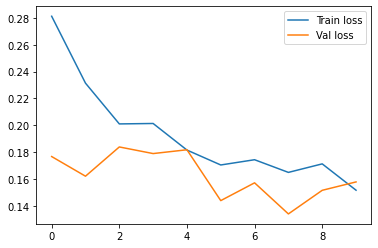

In [ ]:
# visualize performance

plt.plot(range(0, len(training_losses)), training_losses, label='Train MSE')
plt.plot(range(0, len(val_mse_losses)), val_mse_losses, label='Val MSE')
plt.plot(range(0, len(val_mae_losses)), val_mae_losses, label='Val MAE')
plt.legend()
plt.show()

# CNN

In [ ]:
940/40

23.5

In [ ]:
# architecture

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=32, 
                               kernel_size=(64, 64),
                               padding=1)
        # self.conv2 = nn.Conv2d(in_channels=32, 
        #                        out_channels=64, 
        #                        kernel_size=3,
        #                        padding=1)
        # self.conv3 = nn.Conv2d(in_channels=64, 
        #                        out_channels=128, 
        #                        kernel_size=3,
        #                        padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 4), stride=4)

        self.fc1 = nn.Linear(32*1*219, 512)
        self.fc2 = nn.Linear(512, 64)

        self.o_output = nn.Linear(64, 1)
        self.c_output = nn.Linear(64, 1)
        self.e_output = nn.Linear(64, 1)
        self.a_output = nn.Linear(64, 1)
        self.n_output = nn.Linear(64, 1)
        self.i_output = nn.Linear(64, 1)

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        # x = F.relu(self.conv2(x))
        # x = self.maxpool(x)
        # x = F.relu(self.conv3(x))
        # x = self.maxpool(x)

        flattened = x.view(-1, 32*1*219)

        x = F.relu(self.fc1(flattened))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        o_out = self.o_output(x)
        c_out = self.c_output(x)
        e_out = self.e_output(x)
        a_out = self.a_output(x)
        n_out = self.n_output(x)
        i_out = self.i_output(x)

        return [o_out, c_out, e_out, a_out, n_out, i_out]

In [ ]:
# device = torch.device('cpu')
# model = CNNModel().to(device)
# train_iterator, val_iterator, len_train_iterator, len_val_iterator = build_dali_pipeline('cpu')
# batch = next(iter(train_iterator))
# b_input, b_labels = batch[0]['mel_specgram_db'], batch[0]['labels']
# print('input:', b_input.shape)
# b_input = b_input.unsqueeze(1)
# out = model.forward(b_input)
# out.shape

In [ ]:
# train step

def train(device, 
          model, 
          train_iterator, 
          len_train_iterator, 
          optimizer, 
          epoch, 
          WANDB):
    train_loss = 0
    model.train()

    for batch in tqdm(train_iterator, total=len_train_iterator):
        b_input, b_labels = batch[0]['mel_specgram_db'], batch[0]['labels']
        b_input, b_labels = b_input.unsqueeze(1).to(device), b_labels.to(device)
        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        logits = model.forward(b_input)
        # calc loss
        loss = 0
        for idx, logit in enumerate(logits):
            loss += F.mse_loss(logit, b_labels[idx])
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
    
    avg_train_loss = train_loss / len_train_iterator
    print('Training MSELoss:', avg_train_loss)

    if WANDB:
        wandb.log({'train/mse_loss': avg_train_loss})

    return avg_train_loss

In [ ]:
# validation step

def val(device, 
        model, 
        val_iterator, 
        len_val_iterator, 
        epoch, 
        WANDB):
    val_loss = 0
    pred, true = [], []

    model.eval()
    for batch in val_iterator:
        b_input, b_labels = batch[0]['mel_specgram_db'], batch[0]['labels']
        b_input, b_labels = b_input.unsqueeze(1).to(device), b_labels.to(device)

        with torch.no_grad():
            logits = model.forward(b_input)

            # calc loss
            loss = 0
            for idx, logit in enumerate(logits):
                loss += F.mse_loss(logit, b_labels[idx])
            val_loss += loss.item()

            labels = b_labels.cpu().numpy()

            for logit in logits:
                pred.extend(logit.cpu().numpy())
            for label in labels:
                true.extend(label)

    avg_val_loss = val_loss / len_val_iterator
    print('Validation MSELoss:', avg_val_loss)
    val_mae = mean_absolute_error(true, pred)
    print('Validation MAE:', val_mae)

    if WANDB:
        wandb.log({'val/mse_loss': avg_val_loss, 'val/mae_loss': val_mae})
    return avg_val_loss, val_mae

In [ ]:
def run(config, WANDB=False, run_name=''):
    if WANDB:
        wandb.init(name=run_name, 
                   config=config,
                   project="Engage-AI-Recruiter",
                   entity="prithvi_jaunjale")

    device = torch.device(config['device'])
    torch.cuda.empty_cache()
    torch.manual_seed(config['seed'])
    
    model = CNNModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'])

    # get data iterators
    train_iterator, val_iterator, len_train_iterator, len_val_iterator = build_dali_pipeline('gpu')

    if WANDB:
        wandb.watch(model)

    training_losses, val_mse_losses, val_mae_losses = [], [], []
    min_val_mae = float('inf')
    for epoch in range(config['epochs']):
        print('Epoch ' + str(epoch))
        avg_train_loss = train(device, 
                               model, 
                               train_iterator, 
                               len_train_iterator, 
                               optimizer, 
                               epoch, 
                               WANDB)
        avg_val_loss, val_mae = val(device, 
                                    model, 
                                    val_iterator, 
                                    len_val_iterator, 
                                    epoch, 
                                    WANDB)
        training_losses.append(avg_train_loss)
        val_mse_losses.append(avg_val_loss)
        val_mae_losses.append(val_mae)

        train_iterator.reset()
        val_iterator.reset()

        if config['save_best_model']:
            if val_mae < min_val_mae:
                print(f'--- Best Model. Val MAE: {min_val_mae} -> {val_mae}') 
                min_val_mae = val_mae
                best_model = copy.deepcopy(model)

    return (best_model, training_losses, val_mse_losses, val_mae_losses)


In [ ]:
# run

import logging
import os
logger = logging.getLogger('wandb')
logger.setLevel(logging.ERROR)
os.environ['WANDB_NOTEBOOK_NAME'] = 'engage_audio_model'

config = {'device': 'cuda', 
          'epochs': 20, 
          'lr': 0.001, 
          'seed': 42,
          'loss': 'MSELoss',
          'optimizer ': 'AdamW',
          'save_best_model': True}

out = run(config, 
          WANDB=True, 
          run_name='cnn_melspectrograms-0')

best_model, training_losses, val_mse_losses, val_mae_losses = out

/usr/local/lib/python3.6/dist-packages/nvidia/dali/plugin/base_iterator.py:124: Warning: Please set `reader_name` and don't set last_batch_padded and size manually  whenever possible. This may lead, in some situations, to miss some  samples or return duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
/usr/local/lib/python3.6/dist-packages/nvidia/dali/plugin/base_iterator.py:124: Warning: Please set `reader_name` and don't set last_batch_padded and size manually  whenever possible. This may lead, in some situations, to miss some  samples or return duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 144.16896047172222


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.13329535753143076
Validation MAE: 0.12457751
--- Best Model. Val MAE: inf -> 0.12457750737667084
Epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.2597188251187103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.15418008623682722
Validation MAE: 0.12991165
Epoch 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.23082563807867995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.13616999139895244
Validation MAE: 0.1232329
--- Best Model. Val MAE: 0.12457750737667084 -> 0.123232901096344
Epoch 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.23186076978089834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.14105002080299417
Validation MAE: 0.123012
--- Best Model. Val MAE: 0.123232901096344 -> 0.1230119988322258
Epoch 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.21348586494121888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.17147445435426673
Validation MAE: 0.12386489
Epoch 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.20389459214427255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.12798688621545323
Validation MAE: 0.12112253
--- Best Model. Val MAE: 0.1230119988322258 -> 0.12112253159284592
Epoch 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.20454381003674835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.14901134736683905
Validation MAE: 0.122340396
Epoch 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.1972330685968351


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1314040950822587
Validation MAE: 0.123614915
Epoch 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.20005788281559944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1421018933915362
Validation MAE: 0.12262548
Epoch 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.18464869761256256


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.16028151121370646
Validation MAE: 0.12796535
Epoch 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.19789077522176685


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1396318899125469
Validation MAE: 0.12684372
Epoch 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.18766397467315798


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.14080981735368164
Validation MAE: 0.12250549
Epoch 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.1847380671010475


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.12749107866262904
Validation MAE: 0.12498458
Epoch 13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.18423305060526338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1524844542145729
Validation MAE: 0.1252389
Epoch 14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.17456690455325927


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1534469453047733
Validation MAE: 0.124462634
Epoch 15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.18019918201848714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.14117064144538374
Validation MAE: 0.123082645
Epoch 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.1714206554672935


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.16895591057076745
Validation MAE: 0.12393381
Epoch 17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.16914806616577235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.130429920949498
Validation MAE: 0.12109938
--- Best Model. Val MAE: 0.12112253159284592 -> 0.12109938263893127
Epoch 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.16929496373191025


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.14742592980667035
Validation MAE: 0.12157081
Epoch 19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Training MSELoss: 0.16025498567732296


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation MSELoss: 0.1340466580372684
Validation MAE: 0.122339375
